In [ ]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# Data Augmentation
from torchvision import transforms
train_tranformer = transforms.Compose([transforms.RandomHorizontalFlip() ,transforms.RandomRotation(15), transforms.ToTensor()])

# Tranforming automatically does Normalisation
test_tranformer = transforms.ToTensor()


In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(".", train=True, download=True, transform=train_tranformer)

test_dataset = torchvision.datasets.FashionMNIST(".", train=False, download=True, transform=test_tranformer)

100%|██████████| 26.4M/26.4M [00:00<00:00, 118MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.81MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 64.1MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.5MB/s]


In [ ]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

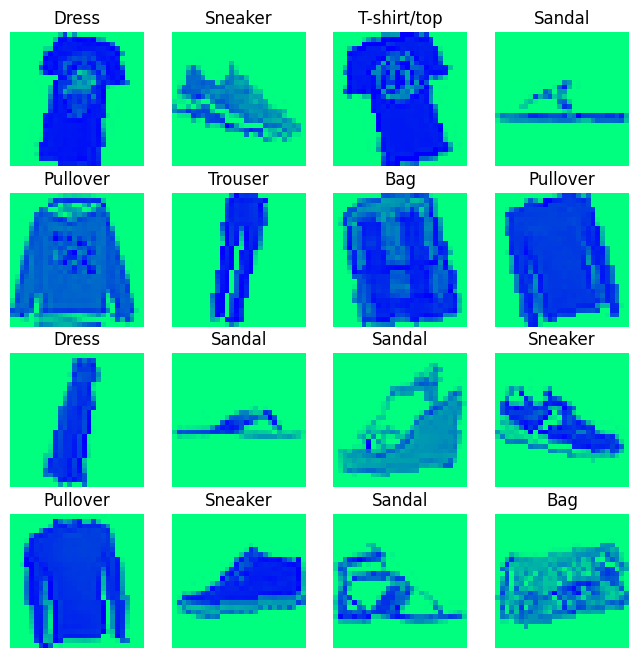

In [ ]:
# Plot the images in a 5x5 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for ax in axes.flatten():
    rand_idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[rand_idx]
    ax.imshow(img.squeeze().numpy(), cmap= "winter_r")
    ax.set_title(class_names[label])
    ax.axis("off")

plt.show()

In [ ]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.85* len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # 1st conv layer: input channel = 1 (grayscale), output = 32 filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # 2nd conv layer: input = 32, output = 64 filters
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # MaxPooling layer to downsample (2x2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Dropout 25% neurons will training to improve subnetworks - Reduce Overfitting
        self.dropout = nn.Dropout(0.25)

        # After pooling twice, 28x28 becomes 7x7, nn.Linear(Input, Output)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conv1 → ReLU → Pool (1st Layer)
        x = self.pool(F.leaky_relu(self.conv1(x)))  # Output: [B, 32, 14, 14]
        # Conv2 → ReLU → Pool (2nd Layer)
        x = self.pool(F.leaky_relu(self.conv2(x)))  # Output: [B, 64, 7, 7]
        #Drop after convs
        x = self.dropout(x)
        # Flatten: [B, 64, 7, 7] → [B, 3136] before using FCNN
        x = x.view(x.size(0), -1)

        # FC1 → ReLU (3rd Layer)
        x = F.relu(self.fc1(x))
        #Dropout randomly again
        x = self.dropout(x)
        # FC2 → Output (4th Layer)
        x = self.fc2(x)
        return x


In [ ]:
import torch.optim as optim

# Instantiate model
model = CNNModel()

#Loss Function
criterion = nn.CrossEntropyLoss()

#Optimizer Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50
device = torch.device("cuda")

model.to(device)

train_losses = []
train_accuracies = []

best_val_loss = float('inf')
patience = 5
counter = 0
best_model_state = None

for epoch in range(num_epochs):
    #Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        #Computing loss y_pred, y
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()      # Clear old gradients
        loss.backward()            # Backpropagation
        optimizer.step()           # Update weights - One step of Gradient Descent

        # Track metrics
        running_loss += loss.item() #Convert tensor loss into float running loss
        _, predicted = torch.max(outputs, 1) # Output is matrix of size (batch_size, num_classes), for each row, we take the max logit out of all classes
        # no.of total predictions made (pred_P + pred_N)
        total += labels.size(0)
        # no.of correct predictions (TP+TN)
        correct += (predicted == labels).sum().item()

    # Print epoch summary
    epoch_loss = running_loss / len(train_loader)
    #Acc = (TP+FP)/Total
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    #Store the metrics after each epoch
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    #Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            #Move to device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            #Forward Pass
            output = model(val_images)
            loss = criterion(output, val_labels)
            val_loss += loss.item()

            _,predicted = torch.max(output, 1)
            val_total += val_labels.size(0)
            val_correct += (predicted == val_labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * (val_correct/val_total)

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    #EARLY STOP
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("🛑 Early stopping triggered!")
            break


model.load_state_dict(best_model_state)

Epoch [1/50], Loss: 0.6289, Accuracy: 76.89%
Validation Loss: 0.4295, Accuracy: 84.04%
Epoch [2/50], Loss: 0.4378, Accuracy: 84.02%
Validation Loss: 0.3539, Accuracy: 87.14%
Epoch [3/50], Loss: 0.3865, Accuracy: 85.86%
Validation Loss: 0.3455, Accuracy: 87.06%
Epoch [4/50], Loss: 0.3580, Accuracy: 86.71%
Validation Loss: 0.3261, Accuracy: 87.64%
Epoch [5/50], Loss: 0.3305, Accuracy: 87.69%
Validation Loss: 0.2950, Accuracy: 89.02%
Epoch [6/50], Loss: 0.3160, Accuracy: 88.16%
Validation Loss: 0.2848, Accuracy: 89.99%
Epoch [7/50], Loss: 0.3048, Accuracy: 88.74%
Validation Loss: 0.2780, Accuracy: 89.47%
Epoch [8/50], Loss: 0.2940, Accuracy: 89.24%
Validation Loss: 0.2678, Accuracy: 89.93%
Epoch [9/50], Loss: 0.2831, Accuracy: 89.52%
Validation Loss: 0.2636, Accuracy: 90.39%
Epoch [10/50], Loss: 0.2785, Accuracy: 89.74%
Validation Loss: 0.2560, Accuracy: 90.41%
Epoch [11/50], Loss: 0.2730, Accuracy: 89.95%
Validation Loss: 0.2470, Accuracy: 90.79%
Epoch [12/50], Loss: 0.2647, Accuracy: 90

<All keys matched successfully>

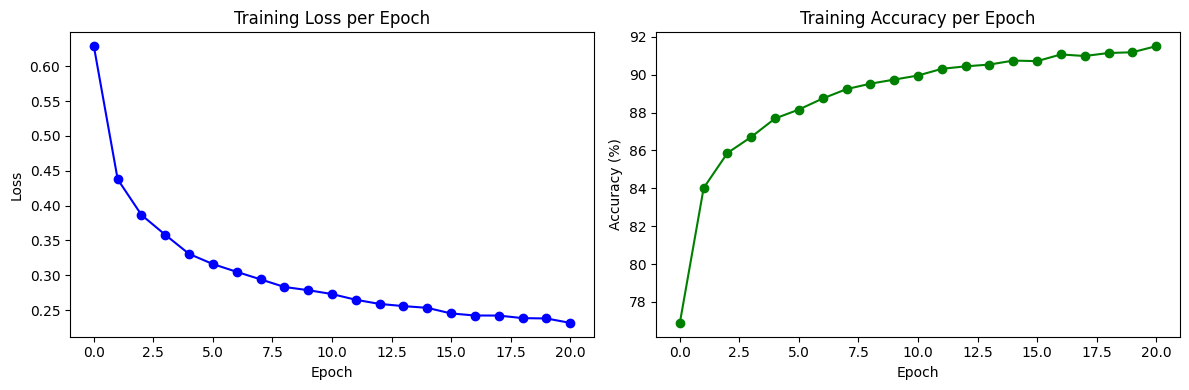

In [ ]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', color='blue')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()


In [ ]:
model.eval()  # Set to eval mode

correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():  # No gradient tracking
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {avg_test_loss:.4f}")

Test Accuracy: 91.20%
Test Loss: 0.2376
